Assignment 8: Open-Set Classification
=====================================


Microsoft Forms Document: https://forms.office.com/r/xY9sQDQdGh

We select the MNIST dataset and define several classes to be known, known unknown (used as negative class during training) and unknown unknown (not used for training at all).

Task 1: Target Vectors
----------------------

For our training dataset, we want to use four classes of MNIST digits (4,5,8,9) as known classes and four (0,2,3,7) as known unknowns. 
The remaining two classes shall be ignored during training and validation, amd only be used for testing purposes.

When we want to train with our adapted softmax function, we need to assign the correct target vectors for the classes. 
These are $(1,0,0,0)$, $(0,1,0,0)$, $(0,0,1,0)$ and $(0,0,0,1)$ for the known classes, respectively. 
For known unknown classes, the target vector is $\left(\frac14,\frac14,\frac14,\frac14\right)$, throughout.


In [12]:
import torch
import torchvision

# define the three types of classes
known_classes = (4,5,8,9)
known_unknown_classes = (0,2,3,7)
unknown_classes = (1,6)
O = len(known_classes)

def target_vector(index):
  # select correct one-hot vector for known classes, and the 1/O-vectors for unknown classes
  if index in known_classes:
    pos = known_classes.index(index)
    return torch.tensor([1 if i == pos else 0 for i in range(O)])
  else:
    return torch.tensor([1 / O for _ in range(O)])

Test 1: Check your Target Vectors
---------------------------------

Test that your target vectors are correct, for all tpyes of known and unknown samples.

In [13]:
# check that the target vectors for known classes are correct
for index in known_classes:
  t = target_vector(index)
  assert t.sum() == 1
  assert t.argmax() == known_classes.index(index)
  assert type(t) == torch.Tensor

# check that the target vectors for unknown classes are correct
for index in known_unknown_classes + unknown_classes:
  t = target_vector(index)
  assert t.sum() == 1
  assert type(t) == torch.Tensor
  

Task 2 and 3: Training Dataset
------------------------
We rely on the MNIST dataset implementation from PyTorch and adapt some parts of it. 
Mainly, we will let PyTorch load the dataset by calling the base class constructor and modify the `self.data` and `self.targets` ourselves.
Additionally, we need to implement the index function to return the data and targets in the desired format.

Since Jupyter Notebook does not allow splitting classes over several code boxes, the two tasks are required to be solved in the same code box.

In [14]:
import numpy as np

class DataSet(torchvision.datasets.MNIST):
  def __init__(self, purpose="train"):
    # call base class constructor to handle the data loading
    super(DataSet, self).__init__(
      ".", train = True if purpose == "train" else False, download=True, transform = torchvision.transforms.ToTensor()
    )

    # select the valid classes based on the current purpose
    # select the valid classes based on the current purpose
    if purpose == "train":
      self.classes = known_classes + known_unknown_classes
    elif purpose == "valid":
      self.classes = known_classes + known_unknown_classes
    elif purpose == "test":
      self.classes = known_classes + unknown_classes

    # check if one element of the list is in another list
    mask = np.column_stack([self.targets == i for i in self.classes]).any(axis=1)
    # sub-select the data of valid classes
    self.data = self.data[mask]
    # select the targets of valid classes
    self.targets = self.targets[mask]

  def __getitem__(self, index):
    # perform appropriate actions on the data and the targets
    (i,t) = super().__getitem__(index)
    target = target_vector(t)
    return i, target

Test 2: Data Sets
-----------------

Instantiate the training dataset.
Implement a data loader for the training dataset with a batch size of 64.
Assure that all inputs are of the desired type and shape.
Assert that the target values are in the correct format, and the sum of the target values per sample is one.

In [15]:
# instantiate the training dataset
train_set = DataSet(purpose="train")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

# assert that we have not filtered out all samples
assert len(train_set.data) == len(train_set.targets)
assert len(train_set.data) > 0

# check the batch and assert valid data and sizes
for i, (x,t) in enumerate(train_loader):
  if i == len(train_loader) - 1:
    continue
  assert x.shape == (64, 1, 28, 28)
  assert t.shape == (64, 4)
  assert torch.all(x <= 1)


Task 4: Utility Function
------------------------

Implement a function that splits a batch of samples into known and unknown parts. For the known parts, also provide the target vectors.
How can we know which of the data samples are known smaples, and which are unknown?

In [16]:
def split_known_unknown(batch, targets):
  # select the indexes at which known and unknown samples exist
  known = torch.any(targets == 1, dim=1)
  unknown = torch.all(targets == 1/4, dim=1)
  # return the known samples, the targets of the known samples, as well as the unknown samples
  return batch[known], targets[known], batch[unknown]

Task 5: Loss Function Implementation
------------------------------------

We implement a loss function that implements an autograd function, i.e., we define both the forward and the backward pass for our loss computation.

In [17]:
class AdaptedSoftMax(torch.autograd.Function):

  # implement the forward propagation
  @staticmethod
  def forward(ctx, logits, targets):
    # compute the log probabilities via log_softmax
    log_probs = torch.nn.functional.log_softmax(logits,dim=1)
    # save required values for backward pass
    ctx.save_for_backward(log_probs, targets)
    # compute loss
    loss = - targets * log_probs
    return torch.sum(loss)

  # implement Jacobian
  @staticmethod
  def backward(ctx, result):
    # get results stored from forward pass
    log_probs, targets = ctx.saved_tensors
    # compute derivative of loss w.r.t. the logits
    dJ_dy = torch.exp(log_probs) - targets
    # return the derivatives; none for derivative for the targets
    return dJ_dy, None

# DO NOT REMOVE!
# here we set the adapted softmax function to be used later
adapted_softmax = AdaptedSoftMax.apply

Task 5a: Alternative Loss Function
----------------------------------

If the implementation of the autograd function in Task 5 is too complicated, we can also rely on PyTorch to compute the gradient for us.
In this case, we only need to define the forward pass, i.e., the loss function itself.

In [18]:
def adapted_softmax_alt(logits, targets):
  # compute cross-entropy loss on top of softmax values of the logits
  #loss = torch.nn.functional.cross_entropy(logits, targets)
  loss = -torch.sum(torch.nn.functional.log_softmax(logits, dim=1) * targets)
  return loss

Task 6: Confidence Evaluation
-----------------------------

Implement a function to compute the confidence value for a given batch of samples. Make sure to split the batch between known and unknown samples, and compute the confidence value for both separately.

In [19]:
def confidence(logits, targets):
  # comupte softmax confidences
  batch = torch.nn.functional.softmax(logits, dim=1)
  # split between known and unknown
  batch_known, targets_known, batch_unknown = split_known_unknown(batch, targets)
  # compute confidence score for known targets
  conf_known = torch.sum(batch_known * targets_known)
  # compute confidence score for unknown targets
  conf_unknown = torch.sum(1 - torch.max(batch_unknown, dim = 1)[0] + 1/4)
  return conf_known + conf_unknown

Test 3: Check Confidence Implementation
---------------------------------------

Test that your confidence implementation does what it is supposed to do.

In [20]:
# select good logit vectors for known and unknown classes
known_logits = torch.diag(torch.ones(4)) * 5 - 4
unknown_logits = torch.ones((4, 4))
logits = torch.vstack((known_logits, unknown_logits))
targets = torch.stack([target_vector(c) for c in known_classes + known_unknown_classes])
# select the according target vectors for these classes
conf = confidence(logits, targets)

# the confidence should be close to 1 for all cases
assert 5 - conf < 0.1

Task 7: Network Definition
--------------------------

We define our own small-scale network to classify known and unknown samples for MNIST.
We basically use the same convolutional network as in Assignment 6, with some small adaptations.
However, this time we need to implement our own network model since we need to modify our network output.

In [21]:
class Network (torch.nn.Module):
  def __init__(self, Q1, Q2, K, O):
    # call base class constrcutor
    super(Network,self).__init__()
    # define convolutional layers
    self.conv1 = torch.nn.Conv2d(1, Q1, (5,5), stride=1, padding=2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, (5,5), stride=1, padding=2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d((2,2), 2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(7*7*Q2, K)
    self.fc2 = torch.nn.Linear(K,O)

  def forward(self,x):
    # compute first layer of convolution, pooling and activation
    a = self.conv1(x)
    a = self.pool(a)
    a = self.act(a)
    # compute second layer of convolution, pooling and activation
    a = self.conv2(a)
    a = self.pool(a)
    a = self.act(a)
    a = self.flatten(a)

    # get the deep features as the output of the first fully-connected layer
    deep_features = self.fc1(a)
    # get the logits as the output of the second fully-connected layer
    logits = self.fc2(deep_features)
    # return both the logits and the deep features
    return logits, deep_features

# run on cuda device
device = torch.device("cuda")
# create network with 20 hidden neurons in FC layer
network = Network(Q1=32, Q2=32, K=20, O=4).to(device)

Task 8: Training Loop
---------------------

Instantiate everything that you need.
Implement the training loop for 100 epochs.
Compute the running training confidence and validation confidence and print them at the end of each epoch.

In [22]:
# SGD optimizer with appropriate learning rate
optimizer = torch.optim.SGD(network.parameters(),lr=0.001, momentum=0.9)

# validation set and data loader
validation_set = DataSet("valid")
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100)

for epoch in range(10): # or 100
  # evaluate average confidence for training and validation set
  train_conf = validation_conf = 0.

  for x,t in train_loader:
    # extract logits (and deep features) from network
    optimizer.zero_grad()
    # extract logits (and deep features) from network
    logits, deep_feature = network(x.to(device))
    # compute our loss
    J = AdaptedSoftMax.apply(logits, t.to(device))
    #J = adapted_softmax_alt(logits, t.to(device))
    J.backward()
    # perform weight update
    optimizer.step()

    # compute training confidence
    with torch.no_grad():
      train_conf += confidence(logits, t.to(device))

  # compute validation comfidence
  with torch.no_grad():
    for x,t in validation_loader:
      # extract logits (and deep features)
      logits, deep_feature = network(x.to(device))
      # compute validation confidence
      validation_conf += confidence(logits, t.to(device))

  # print average confidence for training and validation
  print(f"\rEpoch {epoch}; train: {train_conf/len(train_set):1.5f}, val: {validation_conf/len(validation_set):1.5f}")

Epoch 0; train: 0.88947, val: 0.94526
Epoch 1; train: 0.95130, val: 0.94879
Epoch 2; train: 0.96177, val: 0.96803
Epoch 3; train: 0.96740, val: 0.96889
Epoch 4; train: 0.97026, val: 0.96602
Epoch 5; train: 0.97299, val: 0.97571
Epoch 6; train: 0.97452, val: 0.96964
Epoch 7; train: 0.97735, val: 0.97254
Epoch 8; train: 0.97842, val: 0.97826
Epoch 9; train: 0.98039, val: 0.97324


Task 9: Feature Magnitude Plot
------------------------------

Take the validation and test sets and plot their feature magnitude as histogram, based on the pre-trained network and split between known, known unknown (validation set) and unknown unknown (test set).

Text(0, 0.5, 'Density')

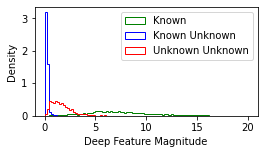

In [23]:
# instantiate test set and according data loader
test_set = DataSet("test")
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100)

# collect feature magnitudes for 
known, known_unknown, unknown = [], [], []

with torch.no_grad():
  # extract deep features magnitudes for validation set
  for x,t in validation_loader:
    # extract deep features (and logits)
    logits, deep_feature = network(x.to(device))
    # compute norms
    nr = torch.norm(deep_feature, dim=1)
    # split between known and unknown
    k, kt, uk = split_known_unknown(nr, t)
    # collect norms of known samples
    known.extend(k.tolist())
    # collect norms of known unknwown samples
    known_unknown.extend(uk.tolist())

  for x,t in test_loader:
    # extract deep features (and logits)
    _, f = network(x.to(device))
    # compute norms
    nr = torch.norm(f, dim=1)
    # split between known and unknown
    k, kt, uk = split_known_unknown(nr, t)
    # collect norms of known samples
    known.extend(k.tolist())
    # collect norms of unknown unknown samples
    unknown.extend(uk.tolist())

# plot the norms as histograms
from matplotlib import pyplot
pyplot.figure(figsize=(4,2))

# keep the same maximum magnitude; I could also compute it, but I am too lazy.
max_mag = 20
# plot the three histograms
pyplot.hist(known, bins=100, range=(0,max_mag), density=True, color="g", histtype="step", label="Known")
pyplot.hist(known_unknown, bins=100, range=(0,max_mag), density=True, color="b", histtype="step", label="Known Unknown")
pyplot.hist(unknown, bins=100, range=(0,max_mag), density=True, color="r", histtype="step", label="Unknown Unknown")

# beautify plot
pyplot.legend()
pyplot.xlabel("Deep Feature Magnitude")
pyplot.ylabel("Density")

Task 10: Classification Evaluation
----------------------------------

For a fixed threshold of $\tau=0.98$, compute CCR and FPR for the test set.
A well-trained network can achieve a CCR of > 90% for an FPR < 10%.
You might need to vary the threshold.

In [24]:
tau = 0.98

# count the correctly classified and the total number of known samples
correct = known = 0
# count the incorrectly classified and the total number of unknown samples
false = unknown = 0

with torch.no_grad():
  for x,t in test_loader:
    # extract logits (and deep features)
    ...
    # compute softmax confidences
    ...
    # split between known and unknown
    ...

    # compute number of correctly classified knowns above threshold
    correct += ...
    known += ...

    # compute number of incorrectly accepted known samples
    false += ...
    unknown += ...

# print both rates
print (f"CCR: {correct} of {known} = {correct/known*100:2.2f}%")
print (f"FPR: {false} of {unknown} = {false/unknown*100:2.2f}%")


TypeError: unsupported operand type(s) for +=: 'int' and 'ellipsis'